In [1]:

# cd drive/MyDrive/Colab\ Notebooks/


In [2]:
# ls

# Imports + Setup

In [100]:
import os, re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import random

In [101]:
# Set seeds for reproducibility
import random
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
torch.backends.cudnn.benchmark = False      # Disable auto-tuner that can introduce randomness

In [102]:
# File Mapping
h_map = {2: 0.0375, 3: 0.084, 6: 0.1575}
flux_map = {88: 25900, 78: 21250, 73: 19400}
abs_map = {0: 3, 92: 100}
surf_map = {0: 0.98, 1: 0.76}
pattern = r"h(\d+)_flux(\d+)_abs(\d+)(?:_[A-Za-z0-9]+)*_surf([01])(?:_[A-Za-z0-9]+)*[\s_]+(\d+)s\b"
# Depending on where u store the data files
# cd drive/MyDrive/Colab\ Notebooks/Theoretical_VTDP
# DATA_DIR = "data/all_processed_time_reset"
# DATA_DIR = "data/all_processed"
DATA_DIR = "data/new_processed_reset"
# DATA_DIR = "../../../data/Theoretical_VTDP"

# DATA_DIR = "Theoretical_VTDP/"
DROP_COLS = ["TC_9_5", "TC_Bottom_rec_groove", "TC_wall_ins_ext", "TC_bottom_ins_groove", "Theoretical_Temps_11"]

# Utilities

In [103]:
def parse_filename_params(filename):
    m = re.search(pattern, filename)
    if not m:
        return None
    h_raw    = int(m.group(1))
    flux_raw = int(m.group(2))
    abs_raw  = int(m.group(3))
    surf_raw = int(m.group(4))
    t        = int(m.group(5))

    # keeping number if no entry exists
    h    = h_map.get(h_raw,    h_raw)
    flux = flux_map.get(flux_raw, flux_raw)
    abs_ = abs_map.get(abs_raw,  abs_raw)
    surf = surf_map.get(surf_raw)

    return h, flux, abs_, surf, t

def load_and_process_file(path, h, flux, abs_val, surf, min_time, filename):
    """Automatically computes cooling rates (C/s) from Time and TC_* columns"""
    df = pd.read_csv(path, encoding="utf-8-sig")
    df = df[df["Time"] >= min_time].copy()
     
    df.drop(columns=[col for col in df.columns if col in DROP_COLS or col.startswith("Depth_")], inplace=True)
    df["h"] = h
    df["flux"] = flux
    df["abs"] = abs_val
    df["surf"] = surf
    df["filename"] = filename
    
    return df.iloc[1:]



# Load and Combine Data

In [ ]:
# dataframes = []
# for fname in os.listdir(DATA_DIR):
#     if not fname.endswith(".csv"):
#         continue

#     params = parse_filename_params(fname)
#     if params is None or params[3] is None:
#         print("Skipping (unmatched):", fname)
#         continue

#     path = os.path.join(DATA_DIR, fname)
#     df = load_and_process_file(path, *params, filename=fname)
#     dataframes.append(df)
    
# data = pd.concat(dataframes, ignore_index=True)
# print(data.info())
# print(data.head())

Skipping (unmatched): cleaned_h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping (unmatched): cleaned_h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25103 entries, 0 to 25102
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time                  25103 non-null  int64  
 1   TC1_tip               25103 non-null  float64
 2   TC2                   25103 non-null  float64
 3   TC3                   25103 non-null  float64
 4   TC4                   25103 non-null  float64
 5   TC5                   25103 non-null  float64
 6   TC6                   25103 non-null  float64
 7   TC7                   25103 non-null  float64
 8   TC8                   25103 non-null  float64
 9   TC9                   25103 non-null  float64
 10  TC10                  25103 non-null  float64
 11  Theoretical_Temps_1   25103 non-null  float64
 

# H6 Only Dataset

In [104]:
dataframes = []
for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".csv"):
        continue

    params = parse_filename_params(fname)
    if params is None or params[3] is None:
        print("Skipping (unmatched):", fname)
        continue

    h_val = params[0]
    if h_val != h_map[6]:  # Only include h6 = 0.1575
        print("Skipping (not h6):", fname)
        continue

    path = os.path.join(DATA_DIR, fname)
    df = load_and_process_file(path, *params,filename=fname)
    dataframes.append(df)
    data = pd.concat(dataframes, ignore_index=True)
print(data.info())
print(data.head())


Skipping (not h6): cleaned_h2_flux88_abs0_mr_surf0_571s - Sheet1_processed.csv
Skipping (not h6): cleaned_h2_flux88_abs0_surf0_431s - Sheet1_processed.csv
Skipping (not h6): cleaned_h2_flux88_abs0_surf0_585s - Sheet2_processed.csv
Skipping (not h6): cleaned_h2_flux88_abs0_surf0_probeUp_590s - Sheet2_processed.csv
Skipping (not h6): cleaned_h2_flux88_abs0_wr_surf0_368s - Sheet1_processed.csv
Skipping (not h6): cleaned_h2_flux88_abs25_newSalt_surf0_172s - Sheet1_processed.csv
Skipping (not h6): cleaned_h2_flux88_abs25_newSalt_wr_surf0_123s - Sheet1_processed.csv
Skipping (not h6): cleaned_h2_flux88_abs25_surf0_493s - Sheet1_processed.csv
Skipping (not h6): cleaned_h2_flux88_abs25_wr_surf0_393s - Sheet1_processed.csv
Skipping (not h6): cleaned_h2_flux88_abs92_surf0_115s - Sheet1_processed.csv
Skipping (not h6): cleaned_h2_flux88_abs92_surf0_probeUp_193s - Sheet1_processed.csv
Skipping (not h6): cleaned_h2_flux88_abs92_wr_surf0_215s - Sheet1_processed.csv
Skipping (not h6): cleaned_h3_flux

# Preprocessing

In [ ]:
if data is not None and not data.empty:
    print("\nStarting preprocessing...")
    
    # Save Time range for inference
    time_min = data["Time"].min()
    time_max = data["Time"].max()
    joblib.dump({"time_min": time_min, "time_max": time_max}, "time_range.pkl")

    # Normalize Time and create Time² feature BEFORE splitting
    data["Time_norm"] = (data["Time"] - time_min) / (time_max - time_min)
    data["Time²"] = data["Time_norm"] ** 2

    # Identify columns
    theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
    tc_cols = [col for col in data.columns if col.startswith("TC") and not col.endswith("_rate")]
    
    print(f"Found {len(theory_cols)} theoretical temperature columns")
    print(f"Found {len(tc_cols)} TC sensor columns")
    
    # Prepare features and targets
    y = data[tc_cols].copy()
    y_columns = y.columns
    X_full = data[["Time_norm", "Time²", "h", "flux", "abs", "surf"] + theory_cols].copy()
    filenames = data["filename"] if "filename" in data.columns else pd.Series(["unknown"] * len(data))

    print(f"Feature matrix shape: {X_full.shape}")
    print(f"Target matrix shape: {y.shape}")

    # Check for missing values
    print(f"\nMissing values in X: {X_full.isnull().sum().sum()}")
    print(f"Missing values in y: {y.isnull().sum().sum()}")
    
    # Remove rows with missing values if any
    if X_full.isnull().sum().sum() > 0 or y.isnull().sum().sum() > 0:
        print("Removing rows with missing values...")
        mask = ~(X_full.isnull().any(axis=1) | y.isnull().any(axis=1))
        X_full = X_full[mask].reset_index(drop=True)
        y = y[mask].reset_index(drop=True)
        filenames = filenames[mask].reset_index(drop=True)
        print(f"After removing missing values - X shape: {X_full.shape}, y shape: {y.shape}")

    # Train-test split
    X_train_raw, X_temp_raw, y_train_raw, y_temp_raw, filenames_train, filenames_temp = train_test_split(
        X_full, y, filenames, test_size=0.3, random_state=SEED
    )
    X_val_raw, X_test_raw, y_val_raw, y_test_raw, filenames_val, filenames_test = train_test_split(
        X_temp_raw, y_temp_raw, filenames_temp, test_size=0.5, random_state=SEED
    )

    print(f"\nTrain set: {X_train_raw.shape[0]} samples")
    print(f"Validation set: {X_val_raw.shape[0]} samples")
    print(f"Test set: {X_test_raw.shape[0]} samples")
    print("Train Files:", filenames_train.unique().tolist())
    print("Val Files:", filenames_val.unique().tolist())
    print("Test Files:", filenames_test.unique().tolist())

    # Check if we have valid data for scaling
    if X_train_raw.empty or y_train_raw.empty:
        print("ERROR: Training data is empty!")
    else:
        print("\nScaling data...")
        # Scaling
        X_scaler = MinMaxScaler()
        X_train_scaled = X_scaler.fit_transform(X_train_raw)
        X_val_scaled = X_scaler.transform(X_val_raw)
        X_test_scaled = X_scaler.transform(X_test_raw)

        y_scaler = MinMaxScaler()
        y_train_scaled = y_scaler.fit_transform(y_train_raw)
        y_val_scaled = y_scaler.transform(y_val_raw)
        y_test_scaled = y_scaler.transform(y_test_raw)

        # Save scalers
        joblib.dump(X_scaler, "X_scaler.pkl")
        joblib.dump(y_scaler, "y_scaler.pkl")
        print("Scalers saved successfully")

        # Convert to tensors and create DataLoader
        train_dataset = TensorDataset(
            torch.tensor(X_train_scaled, dtype=torch.float32), 
            torch.tensor(y_train_scaled, dtype=torch.float32)
        )
        val_dataset = TensorDataset(
            torch.tensor(X_val_scaled, dtype=torch.float32), 
            torch.tensor(y_val_scaled, dtype=torch.float32)
        )
        test_dataset = TensorDataset(
            torch.tensor(X_test_scaled, dtype=torch.float32), 
            torch.tensor(y_test_scaled, dtype=torch.float32)
        )

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        print("Data preprocessing completed successfully!")
        print(f"Ready for training with input size: {X_train_scaled.shape[1]}")
        print(f"Output size: {y_train_scaled.shape[1]}")

else:
    print("ERROR: Cannot proceed with preprocessing - no data was loaded!")
    print("Please check your data directory and file structure.")



Starting preprocessing...
Found 10 theoretical temperature columns
Found 10 TC sensor columns
Feature matrix shape: (21163, 17)
Target matrix shape: (21163, 10)

Missing values in X: 0
Missing values in y: 0

Train set: 14814 samples
Validation set: 3174 samples
Test set: 3175 samples
Train Files: ['cleaned_h6_flux88_abs0_surf0_longRun_762s - Sheet1_processed.csv', 'cleaned_h6_flux78_abs0_surf0_newSalt_641s - Sheet1_processed.csv', 'cleaned_h6_flux88_abs0_surf0_longRun_558s - Sheet2_processed.csv', 'cleaned_h6_flux88_abs20_surf0_longRun_612s - Sheet2_processed.csv', 'cleaned_h6_flux88_abs20_surf0_longRun_780s - Sheet1_processed.csv', 'cleaned_h6_flux78_abs0_surf0_745s - Sheet1_processed.csv', 'cleaned_h6_flux88_abs0_surf0_389s - Sheet4_processed.csv', 'cleaned_h6_flux88_abs0_surf0_longRun_643s - Sheet3_processed.csv', 'cleaned_h6_flux73_abs0_surf0_511s - Sheet3_processed.csv', 'cleaned_h6_flux78_abs0_surf0_523s - Sheet2_processed.csv', 'cleaned_h6_flux88_abs0_surf1_491s - Sheet3_proce

In [ ]:
# # === Filewise Preprocessing (70/15/15 split) ===
# if data is not None:
#     # Normalize Time and create Time² feature BEFORE splitting
#     data["Time_norm"] = (data["Time"] - data["Time"].min()) / (data["Time"].max() - data["Time"].min())
#     data["Time²"] = data["Time_norm"] ** 2
    
#     theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
#     feature_cols = ["Time_norm", "Time²", "h", "flux", "abs", "surf"] + theory_cols
    
#     filenames = data["filename"].unique()
    
#     # Filewise split
#     train_files, temp_files = train_test_split(filenames, test_size=0.3, random_state=SEED)
#     val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=SEED)
    
    
#     # Helper function with updated features
#     def extract_X_y(df):
#         X = df[feature_cols].copy()
#         y = df.drop(columns=feature_cols + ["filename", "Time"], errors='ignore')  # Drop original Time
#         return X.reset_index(drop=True), y.reset_index(drop=True)

        
#     # Helper to filter rows
#     train_data = data[data["filename"].isin(train_files)].copy()
#     val_data = data[data["filename"].isin(val_files)].copy()
#     test_data = data[data["filename"].isin(test_files)].copy()
    
#     X_train_raw, y_train_raw = extract_X_y(train_data)
#     X_val_raw, y_val_raw = extract_X_y(val_data)
#     X_test_raw, y_test_raw = extract_X_y(test_data)

#     y_columns = y_train_raw.columns

#     # For future tracking
#     train_filenames = train_files.tolist()
#     val_filenames = val_files.tolist()
#     test_filenames = test_files.tolist()

#     print("Train Files:", train_filenames)
#     print("Val Files:", val_filenames)
#     print("Test Files:", test_filenames)

#     # Scaling
#     X_scaler = MinMaxScaler()
#     X_train_scaled = X_scaler.fit_transform(X_train_raw)
#     X_val_scaled = X_scaler.transform(X_val_raw)
#     X_test_scaled = X_scaler.transform(X_test_raw)

#     y_scaler = MinMaxScaler()
#     y_train_scaled = y_scaler.fit_transform(y_train_raw)
#     y_val_scaled = y_scaler.transform(y_val_raw)
#     y_test_scaled = y_scaler.transform(y_test_raw)

#     joblib.dump(X_scaler, "X_scaler.pkl")
#     joblib.dump(y_scaler, "y_scaler.pkl")

#     # Convert to tensors and create DataLoader
#     train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_scaled, dtype=torch.float32))
#     val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val_scaled, dtype=torch.float32))
#     test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test_scaled, dtype=torch.float32))

#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
#     test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Train Files: ['cleaned_h6_flux73_abs0_surf0_newSalt_398s - Sheet1_processed.csv', 'cleaned_h6_flux88_abs20_surf0_781s - Sheet2_processed.csv', 'cleaned_h6_flux78_abs0_surf0_745s - Sheet1_processed.csv', 'cleaned_h6_flux88_abs0_surf1_newSalt_573s - Sheet2_processed.csv', 'cleaned_h6_flux88_abs0_surf0_longRun_558s - Sheet2_processed.csv', 'cleaned_h6_flux78_abs0_surf0_newSalt_641s - Sheet1_processed.csv', 'cleaned_h6_flux88_abs20_surf0_longRun_780s - Sheet1_processed.csv', 'cleaned_h6_flux73_abs0_surf0_511s - Sheet3_processed.csv', 'cleaned_h6_flux88_abs0_surf1_491s - Sheet3_processed.csv', 'cleaned_h6_flux73_abs0_surf0_429s - Sheet2_processed.csv', 'cleaned_h6_flux88_abs0_surf0_longRun_762s - Sheet1_processed.csv', 'cleaned_h6_flux88_abs92_mr_surf0_580s - Sheet1_processed.csv', 'cleaned_h6_flux88_abs20_surf1_675s - Sheet3_processed.csv', 'cleaned_h6_flux78_abs0_surf1_newSalt_505s - Sheet3_processed.csv', 'cleaned_h6_flux78_abs0_surf1_newSalt_466s - Sheet1_processed.csv', 'cleaned_h6_flu

# Model

In [106]:
# Model with SiLU and Corrected Residual Connection
class EnhancedThermalNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_layer = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.silu = nn.SiLU()
        self.dropout = nn.Dropout(0.3)

        self.layer1 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.output_layer = nn.Linear(128, output_size)

        # Projection layer for residual connection
        self.residual_proj = nn.Linear(512, 256)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.silu(self.bn1(self.input_layer(x)))
        residual = self.residual_proj(x)
        x = self.dropout(x)
        
        x = self.silu(self.bn2(self.layer1(x)))
        x = self.silu(self.bn3(self.layer2(x)))
        x = x + residual
        x = self.dropout(x)
        
        x = self.silu(self.bn4(self.layer3(x)))
        return self.output_layer(x)


# Training

In [107]:
# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X_train_scaled.shape[1]
output_size = y_train_scaled.shape[1]
model = EnhancedThermalNet(
    input_size=X_train_scaled.shape[1],  # Automatically includes cooling rates
    output_size=y_train_scaled.shape[1]
                           ).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

class EnhancedLoss(nn.Module):
    def __init__(self, smoothness_lambda=0.001):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.smoothness_lambda = smoothness_lambda

    def forward(self, preds, targets):
        mse = self.mse_loss(preds, targets)
        smoothness = torch.mean(torch.abs(preds[:, 1:] - preds[:, :-1]))
        return mse + self.smoothness_lambda * smoothness

criterion = EnhancedLoss()
# Training Loop
EPOCHS = 1000
best_val_loss = float('inf')
patience = 50
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss_epoch = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        train_loss = criterion(predictions, y_batch)
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss_epoch += train_loss.item()
    
    train_loss_epoch /= len(train_loader)
    
    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_preds = model(X_batch)
            val_loss = criterion(val_preds, y_batch)
            val_loss_epoch += val_loss.item()
    
    val_loss_epoch /= len(val_loader)
    scheduler.step()

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, 'best_model_checkpoint.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss_epoch:.6f} Val Loss: {val_loss_epoch:.6f}")

# Load best model
checkpoint = torch.load('best_model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

Epoch [50/1000] Train Loss: 0.003595 Val Loss: 0.002682
Epoch [100/1000] Train Loss: 0.002430 Val Loss: 0.001752
Epoch [150/1000] Train Loss: 0.002860 Val Loss: 0.002205
Early stopping at epoch 180


C:\Users\Rajasekar\AppData\Local\Temp\ipykernel_12856\4062146458.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_checkpoint.pth')


<All keys matched successfully>

# Evaluation

In [108]:
# Evaluation
def evaluate_model(model, loader, scaler):
    model.eval()
    preds = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            pred = model(X_batch).cpu().numpy()
            preds.append(pred)
            y_true.append(y_batch.numpy())
    
    preds = np.concatenate(preds)
    y_true = np.concatenate(y_true)
    preds_real = scaler.inverse_transform(preds)
    y_real = scaler.inverse_transform(y_true)
    rmse = np.sqrt(np.mean((preds_real - y_real) ** 2, axis=0))
    mae = np.mean(np.abs(preds_real - y_real), axis=0)
    y_mean = np.mean(y_real, axis=0)
    ss_tot = np.sum((y_real - y_mean) ** 2, axis=0)
    ss_res = np.sum((y_real - preds_real) ** 2, axis=0)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))
    return preds_real, y_real, rmse, mae, r2

preds_real, y_real, rmse, mae, r2 = evaluate_model(model, test_loader, y_scaler)

print("\n=== Comprehensive Evaluation ===")
print(f"{'Sensor':<15} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'R² Score':<12}")
for i, col in enumerate(y_columns):
    print(f"{col:<15} {rmse[i]:<12.3f} {mae[i]:<12.3f} {r2[i]:<12.3f}")
print(f"\nAverage RMSE: {np.mean(rmse):.3f} °C")
print(f"Average MAE: {np.mean(mae):.3f} °C")
print(f"Average R²: {np.mean(r2):.3f}")


=== Comprehensive Evaluation ===
Sensor          RMSE (°C)    MAE (°C)     R² Score    
TC1_tip         16.498       4.610        0.929       
TC2             16.524       5.114        0.927       
TC3             16.377       5.321        0.931       
TC4             15.931       6.109        0.934       
TC5             15.806       5.578        0.936       
TC6             15.943       6.083        0.936       
TC7             14.480       5.726        0.949       
TC8             12.693       5.880        0.962       
TC9             11.947       5.555        0.968       
TC10            11.514       5.670        0.969       

Average RMSE: 14.771 °C
Average MAE: 5.565 °C
Average R²: 0.944


<!-- ----------------------------------------------------------------------------------------------------------------------------------- -->

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [110]:
def check_and_clip_input(input_df, scaler):
    columns = scaler.feature_names_in_
    min_vals = scaler.data_min_
    max_vals = scaler.data_max_
    clipped = False
    for col, min_val, max_val in zip(columns, min_vals, max_vals):
        if col in input_df.columns:
            out_of_range = (input_df[col] < min_val) | (input_df[col] > max_val)
            if out_of_range.any():
                print(f"Warning: '{col}' has values out of range [{min_val}, {max_val}]. Clipping.")
                input_df[col] = input_df[col].clip(min_val, max_val)
                clipped = True
    if not clipped:
        print("All input values are within the training range.")
    return input_df

In [115]:
# Use a sample from the dataset for inference
new_input = [[0, 0.1575, 25900, 20, 0.98] + [329.386266207629, 352.551499568358, 352.553759702364, 350.275738614983, 339.497145930202, 329.185115858301, 321.851178317625, 319.313289675805, 319.313289675805, 319.313289675805]]
# new_input = [[0, 0.1575, 25900, 20, 0.98]+[308.643914081496,329.496758659629,329.49784608407,327.585348377549,320.864532577509,315.25563745915,311.241414348336,309.692852226731,309.692852226731,309.692852226731]] 
# new_input = [[0,0.1575,25900,20,0.98]+[322.346598107413,344.707379405421,344.707598403347,342.463078051269,332.928870144283,324.216781541098,318.02660925491,315.821244548393,315.821244548393,315.821244548393]]

theory_cols = [f"Theoretical_Temps_{i+1}" for i in range(10)]
input_columns = ["Time", "h", "flux", "abs", "surf"] + theory_cols

new_input_df = pd.DataFrame(new_input, columns=input_columns)

time_range = joblib.load("time_range.pkl")
time_min = time_range["time_min"]
time_max = time_range["time_max"]
new_input_df["Time_norm"] = (new_input_df["Time"] - time_min) / (time_max - time_min + 1e-8)
new_input_df["Time²"] = new_input_df["Time_norm"] ** 2

# Select features in the same order as training
feature_columns = ["Time_norm", "Time²", "h", "flux", "abs", "surf"] + theory_cols
new_input_df = new_input_df[feature_columns]

new_input_df = check_and_clip_input(new_input_df, X_scaler)  # Changed from new_input to new_input_df
new_input_scaled = X_scaler.transform(new_input_df)
new_tensor = torch.tensor(new_input_scaled, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    pred = model(new_tensor).cpu().numpy()
    if np.isnan(pred).any():
        print("Warning: NaN predictions detected!")
    else:
        real_pred = y_scaler.inverse_transform(pred)
        print("\nPredicted Temperatures:", real_pred.flatten().tolist())
# real_pred = y_scaler.inverse_transform(pred)
# print("\nPredicted Temperatures:", real_pred.flatten().tolist())
# 359.94,359.37,360.24,360.78,359.9,362.01,358.77,359.11,355.59,330.85


Predicted Temperatures: [354.1835632324219, 352.10858154296875, 356.6665344238281, 360.1994934082031, 360.9407653808594, 362.9085998535156, 367.8944091796875, 367.23260498046875, 367.5162048339844, 357.6454162597656]


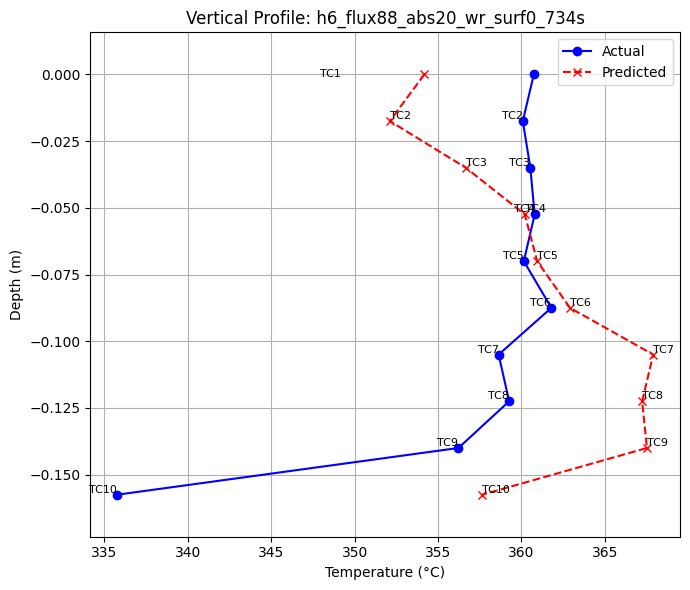

In [116]:
def plot_vertical_profile(predicted, actual, filename="Sample Profile"):
    sensor_labels = [f"TC{i+1}" for i in range(10)]
    total_height = 0.1575  # Total receiver height in meters
    spacing = total_height / 9  # 9 intervals between 10 sensors
    depths = [0 - i * spacing for i in range(10)]  # TC10 at 0, decreasing upwards
    
    plt.figure(figsize=(7, 6))
    plt.plot(actual, depths, label="Actual", color='blue', marker='o')
    plt.plot(predicted, depths, label="Predicted", color='red', marker='x', linestyle='--')
    plt.gca().invert_yaxis()  # Makes negative values go down
    
    # Add extra space (10%) at top and bottom
    y_margin = total_height * 0.10
    plt.ylim(-total_height - y_margin, 0 + y_margin)
    
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Depth (m)")
    plt.title(f"Vertical Profile: {filename}")
    plt.legend()

    # Add sensor labels (TC1 on left, others on right)
    for i, label in enumerate(sensor_labels):
        if i == 0:  # TC1 (top sensor) - place text on the left
            plt.text(min(actual[0], predicted[0]) - 5, depths[0], label, 
                     ha='right', va='center', fontsize=8, color='black')
        else:  # Other sensors - default right placement
            plt.text(actual[i], depths[i], label, ha='right', va='bottom', fontsize=8)
            plt.text(predicted[i], depths[i], label, ha='left', va='bottom', fontsize=8)

    plt.grid(True)
    plt.tight_layout()  # Prevent label cutoff
    plt.show()
    
# Use actual values from the dataset for comparison
actual_values = [360.74, 360.08, 360.53, 360.79, 360.14, 361.79, 358.63, 359.26, 356.22, 335.77]
# actual_values = [359.64,358.86,359.41,359.51,359.17,361.24,358.75,359.21,356.32,336.55]
# actual_values = [359.94,359.37,360.24,360.78,359.9,362.01,358.77,359.11,355.59,330.85]
plot_vertical_profile(real_pred.flatten(), actual_values, filename="h6_flux88_abs20_wr_surf0_734s")
# plot_vertical_profile(real_pred.flatten(), actual_values, filename="h6_flux88_abs20_surf0_389s")
# plot_vertical_profile(real_pred.flatten(), actual_values, filename="h6_flux88_abs20_surf0_longRun_612s")

In [ ]:
# Plot Predicted vs Actual Temperatures for 5 samples from the test set
num_samples = 30
for idx in range(num_samples):
    plt.figure(figsize=(8, 4))
    plt.plot(y_real[idx], label='Actual', marker='o')
    plt.plot(preds_real[idx], label='Predicted', marker='x')
    plt.title(f'Predicted vs Actual Temperatures (Sample {idx})')
    plt.xlabel('Sensor Index')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()

